# Test Facies Simulations Indicators

This file is meant to demonstrate the use of gstlearn by loading a numpy array containing a facies indicator variable simulated by flumy and perform some calculations based on the grid organization (transition probabilities or connectivity)

In [1]:
# Install Flumy
# More information here : https://flumy.minesparis.psl.eu/
#!python3 -m pip install flumy

In [2]:
# Load standard python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load gstlearn
from gstlearn import *
import gstlearn.plot as gp

# Load flumy
from flumy import *

## Generate a Flumy simulation

Use the default Fluvial scenario (with a Net to Gross of 30%)

In [3]:
nx      = 250   # Number of grid nodes along Ox
ny      = 200   # Number of grid nodes along Oy
mesh    = 10    # Horizontal grid mesh size: 10m
hmax    = 3     # Maximum channel depth: 3m
ng      = 30    # Required Net-to-Gross: 30%
isbx    = 80    # Required sand bodies extension (medium extension = few meander cutoffs)
verbose = True  # Verbose mode

res = 30            # Vertical resolution (increase 'res' to get higher resolution)
dz  = hmax / res    # Vertical discretization step (0.1m)
zul = 3 * hmax      # Fill a reservoir of 3 x hmax height (9m)
nz  = int(zul / dz) # Number of vertical nodes of the resulted block of sediments

In [4]:
# Launch the simulation
seed = 123456 # Simulation seed
# Create the simulator
flsim = Flumy(nx, ny, mesh, verbose)
# Launch up to zul
success = flsim.launch(seed, hmax, isbx, ng, zul)
if (not success):
    print("Error while running Flumy")

Flumy (7.402) / 2024-08-28
    Info      : Launching Flumy with:   - MaxDepth = 3m
  - SandBodyIndex = 80, 
  - NetToGross = 30%
    Info      : Flumy Non Expert User (standard):
              :  NEXUS input:
              :   hmax=3m
              :   isbx=80
              :   sand=30%
              :   adapt_grid=0
              :  NEXUS output:
              :   width=30m
              :   e=4e-08
              :   slope=0.001
              :   wavelength=375m
              :   trav=600it
              :   tlvb=312it
              :   tob=39it
              :   iob=0.1m
              :   lambda=892m
              :  Intermediate values:
              :   hmean=2m
              :   cf=0.0158(unit?)
              :   velocity=0.909862m/s
              :   lambda (raw)=900m
              :   ios=0.03m
              :   tav=387.326it
              :  Forecasts:
              :   rel_flw_dir=0deg
              :   adx=2720m
              :   forecast_sand=30%
              :   forecast_a

## Extract one slice from the facies array

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


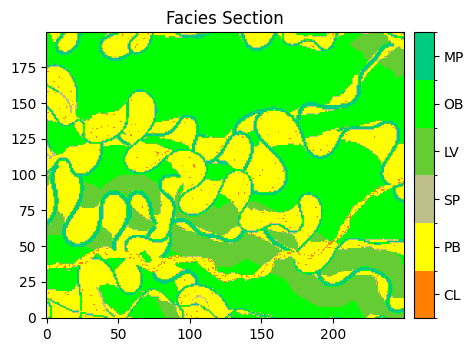

In [5]:
# Retrieve the simulated block informed with facies in a 3D numpy array
fac,grain,age = flsim.getBlock(dz, 0 ,nz)

# Get an horizontal slice at a given index
slice_idx = 10
my_slice = fac[:,:,slice_idx]

# Show the slice
showSection(my_slice, size=5, legend=1)

In [78]:
# Get unique facies list (transpose the slice to make it compatible with gstlearn)
fac_flat = my_slice.transpose().flatten()
ufacies = np.unique(fac_flat)
print("1. Unique facies are ", ufacies)
nfacies = len(ufacies) 

# Grouping facies (see Flumy user guide appendix)
arr_flat = fac_flat
arr_flat[arr_flat==1] = 1 # CL => PB
arr_flat[arr_flat==2] = 1 # PB
arr_flat[arr_flat==3] = 1 # SP => PB
arr_flat[arr_flat==4] = 1 # CS1 => PB
arr_flat[arr_flat==5] = 2 # CS2 => LV
arr_flat[arr_flat==6] = 2 # CCh => LV
arr_flat[arr_flat==7] = 2 # LV
arr_flat[arr_flat==8] = 3 # OB
arr_flat[arr_flat==9] = 4 # MP
arr_lab = ['PB', 'LV', 'OB', 'MP']

ufacies = np.unique(arr_flat)
print("2. Unique facies are ", ufacies)
nfacies = len(ufacies) 

1. Unique facies are  [1 2 3 7 8 9]
2. Unique facies are  [1 2 3 4]


## Import this array in gstlearn

The Grid file is created first (defining the origin, mesh size and count). Then the facies variable is added giving the name and the locator. 

In [79]:
ndim = 2
dx = mesh
dy = mesh
defineDefaultSpace(ESpaceType.RN, ndim)
grid = DbGrid.create([nx,ny],[dx,dy],[0,0])
grid.addColumns(np.double(arr_flat), "fac", ELoc.Z)
if verbose:
    dbfmt = gl.DbStringFormat()
    dbfmt.setFlags(flag_extend=True, flag_stats=True)
    grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 50000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :     10.000    10.000
Number :        250       200

Data Base Extension
-------------------
Coor #1 - Min =      0.000 - Max =   2490.000 - Ext = 2490
Coor #2 - Min =      0.000 - Max =   1990.000 - Ext = 1990

Data Base Statistics
--------------------
1 - Name rank - Locator NA
 Nb of data          =      50000
 Nb of active values =      50000
 Minimum value       =      1.000
 Maximum value       =  50000.000
 Mean value          =  25000.500
 Standard Deviation  =  14433.757
 Variance            = 208333333.250
2 - Name x1 - Locator x1
 Nb of data          =      50000
 Nb of active values =      50000
 Minimum value       =      0.000
 Maximum value       =   2490.000
 Mean value          =   1

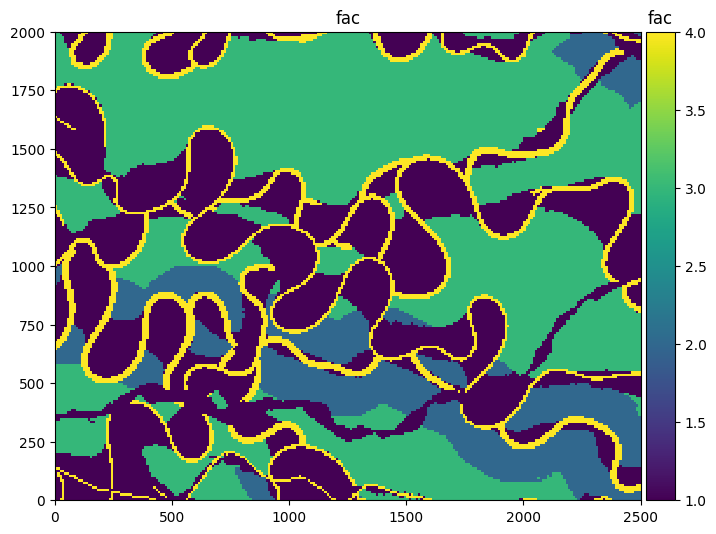

In [80]:
gp.raster(grid,name="fac",flagLegend=True)

## Proportions
Calculate facies global proportions

In [81]:
simu = arr_flat
cnt = Counter(list(simu))
props = [100*cnt[f]/(nx*ny) for f in ufacies]
sprops = ["{:.2f}%".format(p) for p in props]
facs = [f"{fa}" for fa in arr_lab]
df = pd.DataFrame({'Facies': facs, 'Proportions': sprops})
print("Number of Facies:", nfacies)
print(df.to_string(index=False))

Number of Facies: 4
Facies Proportions
    PB      35.49%
    LV      12.73%
    OB      42.33%
    MP       9.45%


## Transition probabilities

Calculate the transition probabilities for the 2 main directions and for each facies identifier

### Transform Facies variable to Indicators

In [82]:
# Transform categorical variable into indicators
limits = Limits(nfacies)
if verbose:
    limits.display()
err = limits.toIndicator(grid, "fac")
# Rename generated variables using Flumy facies short label
for i in range(nfacies):
    grid.setName(f"Indicator.fac.Class.{i+1}", arr_lab[i])
grid

Bound( 1 ) : [ 0.5 ; 1.5 [
Bound( 2 ) : [ 1.5 ; 2.5 [
Bound( 3 ) : [ 2.5 ; 3.5 [
Bound( 4 ) : [ 3.5 ; 4.5 [



Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 50000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :     10.000    10.000
Number :        250       200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = fac - Locator = NA
Column = 4 - Name = PB - Locator = z1
Column = 5 - Name = LV - Locator = z2
Column = 6 - Name = OB - Locator = z3
Column = 7 - Name = MP - Locator = z4

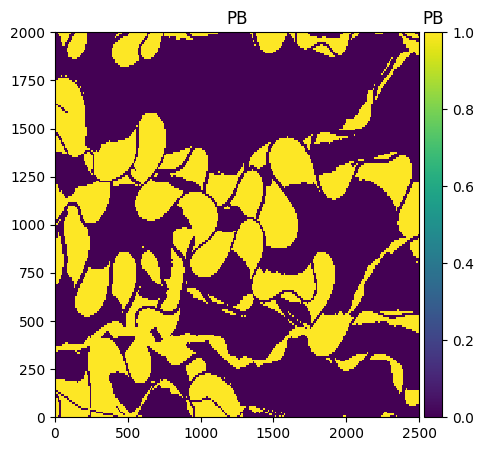

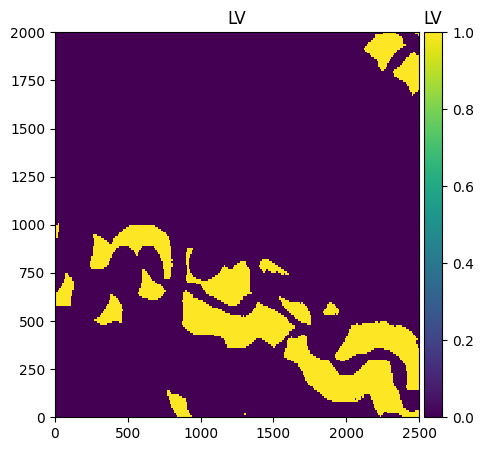

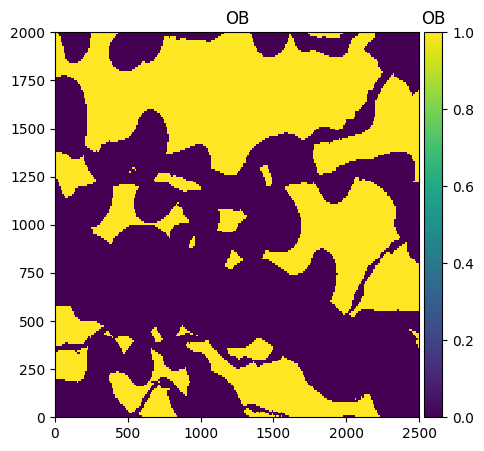

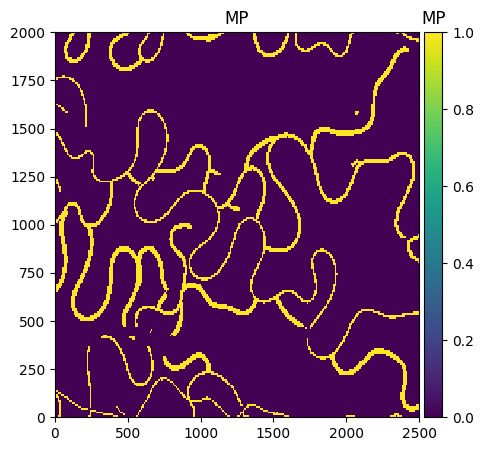

In [83]:
for i in range(nfacies):
    plt.figure(figsize=(5,5))
    gp.raster(grid,name=arr_lab[i],flagLegend=True)

### Calculate Transition probabilities

We want to consider two **directions** of calculation:
- direction #1 : along flow direction (Ox) : gridIncr = [1,0]
- direction #2 : cross flow direction (Oy) : gridIncr = [0,1]

We want to calculate transition in the two **orientations**:
- from facies ivar => jvar: we use gl.ECalcVario.TRANS1
- from facies jvar => ivar: we use gl.ECalcVario.TRANS2

In [84]:
#Prepare variogram parameters
variop = VarioParam()
dir1 = DirParam(40,dx)
dir1.setGrincr([1,0])
dir2 = DirParam(20,dx)
dir2.setGrincr([0,1])
variop.addDir(dir1)
variop.addDir(dir2)

# Calculate transition probabilities in both directions and in both orientations
trans1 = Vario(variop)
err = trans1.compute(grid, gl.ECalcVario.TRANS1)
trans2 = Vario(variop)
err = trans2.compute(grid, gl.ECalcVario.TRANS2)
trans1.display()
trans2.display()


Cross-to_simple Variogram ratio G12/G1
Number of variable(s)       = 4
Number of direction(s)      = 2
Space dimension             = 2
Variable(s)                 = [PB LV OB MP]

Variance-Covariance Matrix
               [,  0]    [,  1]    [,  2]    [,  3]
     [  0,]     0.229     0.197     0.656     0.146
     [  1,]     0.197     0.111     0.485     0.108
     [  2,]     0.656     0.485     0.244     0.164
     [  3,]     0.146     0.108     0.164     0.086

Direction #1
------------
Number of lags              = 40
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =     10.000
Tolerance on distance       =     50.000 (Percent of the lag value)
Grid Direction coefficients =          1         0

For variable 1
      Rank    Npairs  Distance     Value
         1 49800.000    10.000     0.030
         2 49600.000    20.000     0.055
         3 49400.000    30.000

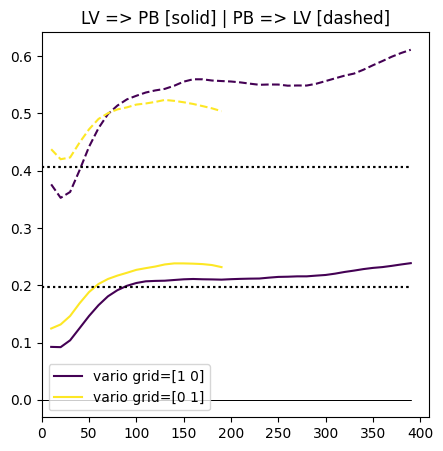

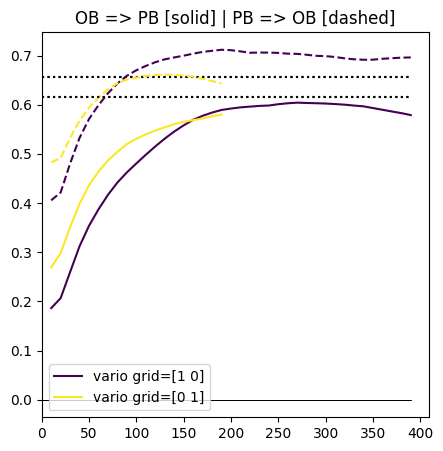

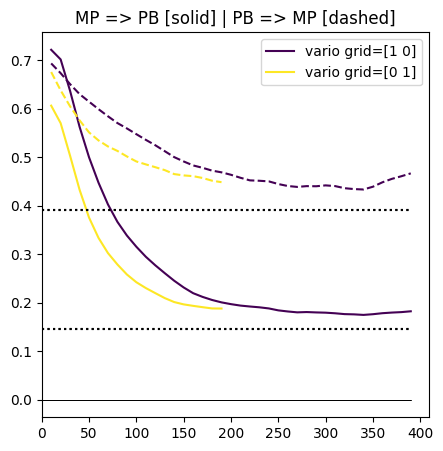

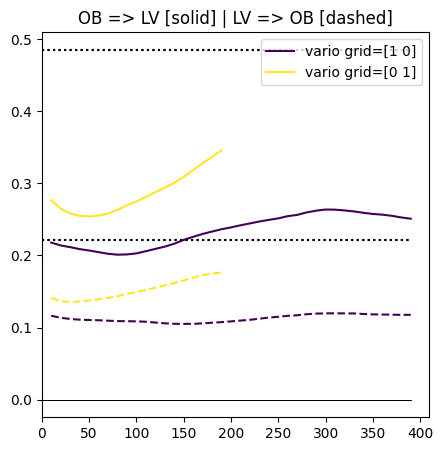

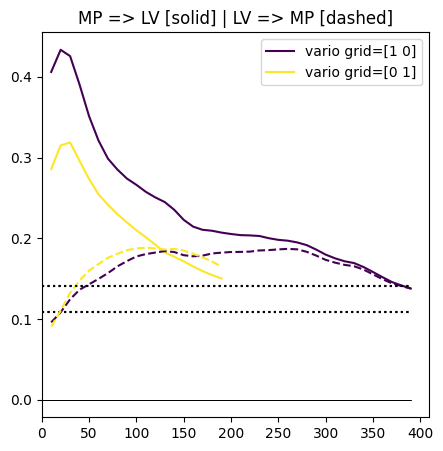

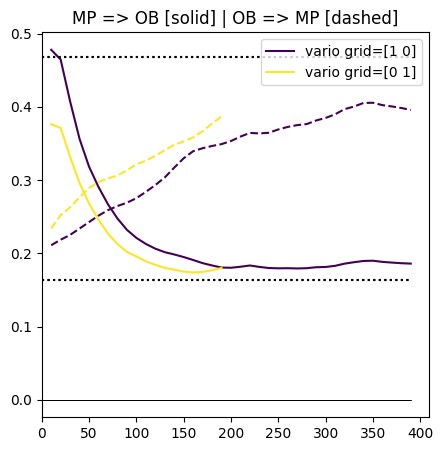

In [85]:
for jvar in range(nfacies):
    for ivar in range(jvar+1,nfacies):
        plt.figure(figsize=(5,5))
        plt.title(f"{arr_lab[ivar]} => {arr_lab[jvar]} [solid] | {arr_lab[jvar]} => {arr_lab[ivar]} [dashed]")
        dummy = gp.varmod(trans1, ivar=ivar, jvar=jvar, varioLinestyle='solid', flagLegend=True)
        dummy = gp.varmod(trans2, ivar=ivar, jvar=jvar, varioLinestyle='dashed')

## Connected Components
Calculate the connected components for each facies.

PB Number of Connected Components = 158 

PB Total Volume of Connected Components = 17744 / 50000 (pixels)



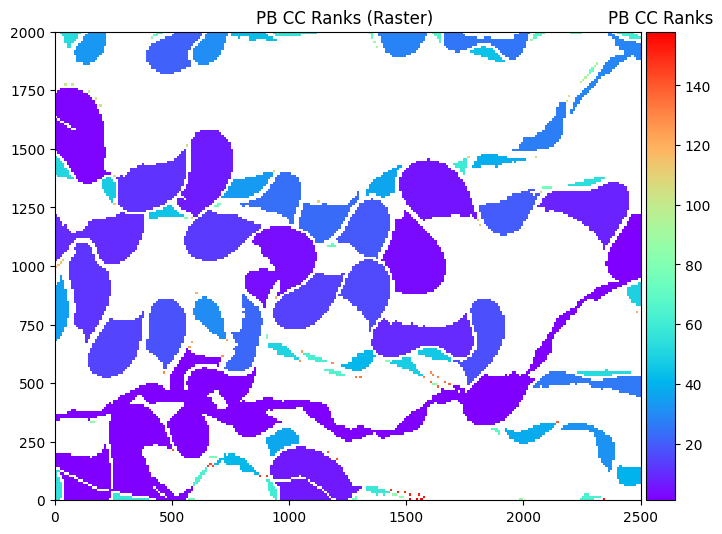

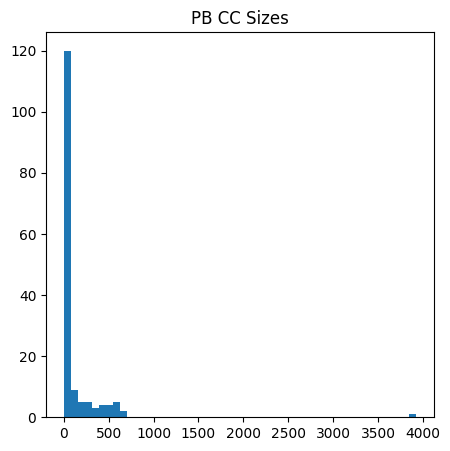

LV Number of Connected Components = 17 

LV Total Volume of Connected Components = 6366 / 50000 (pixels)



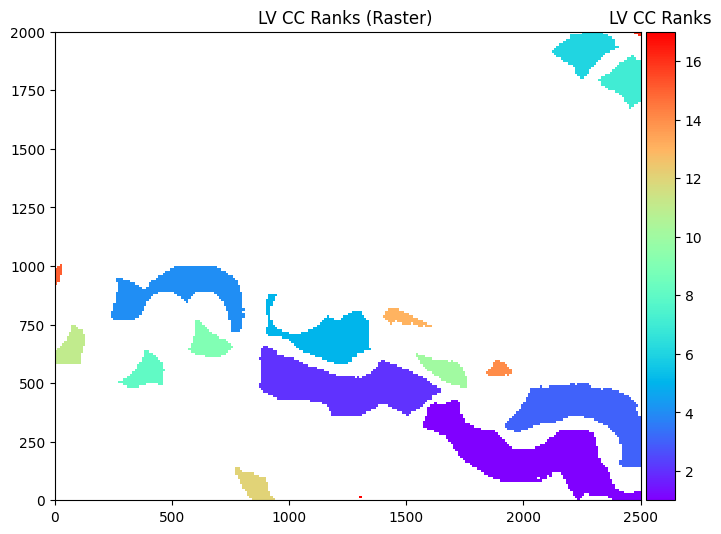

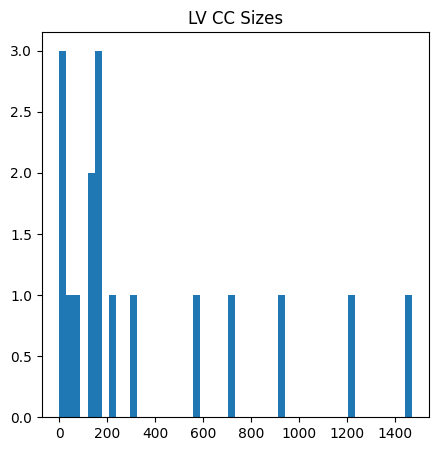

OB Number of Connected Components = 36 

OB Total Volume of Connected Components = 21165 / 50000 (pixels)



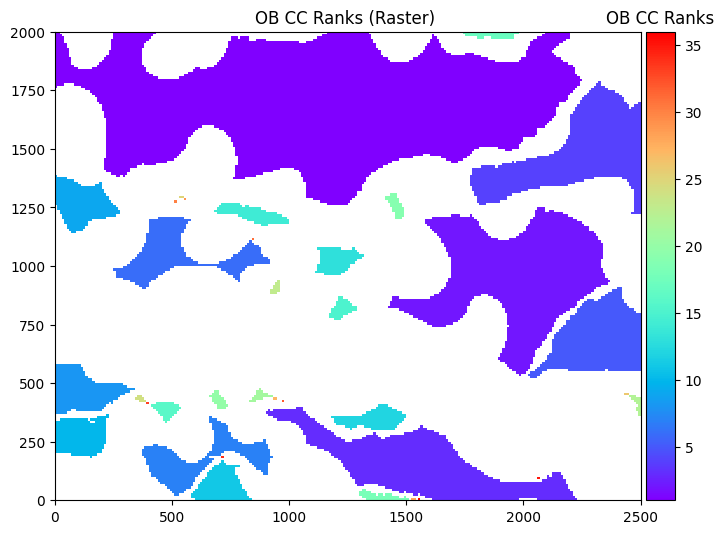

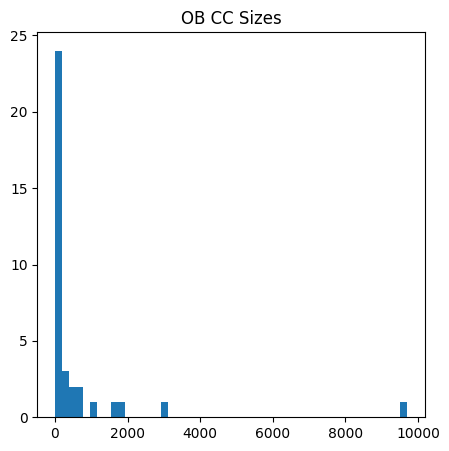

MP Number of Connected Components = 106 

MP Total Volume of Connected Components = 4725 / 50000 (pixels)



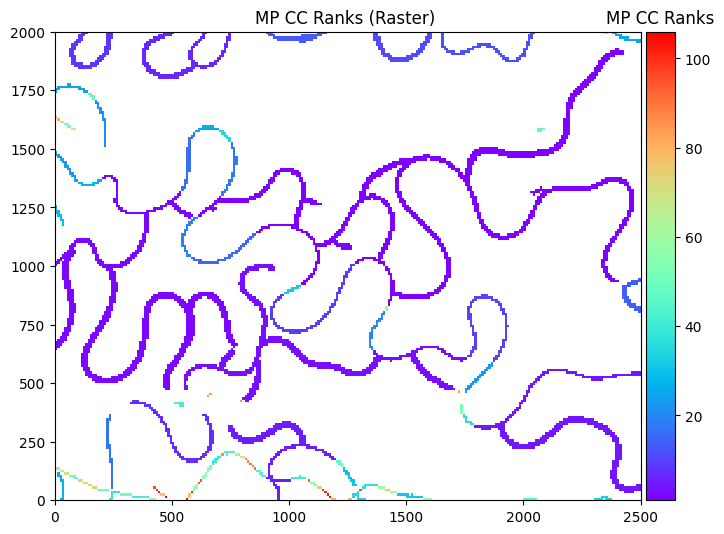

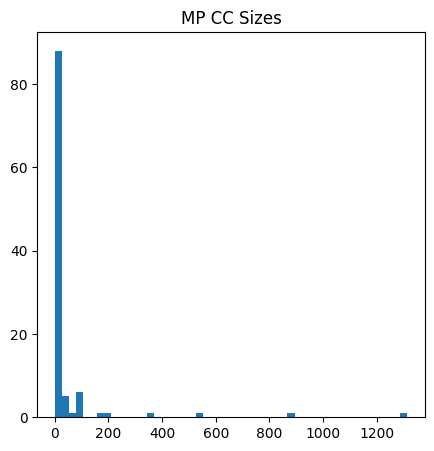

In [90]:
nxy = [nx,ny]
ntotal = nx * ny
eps = 0.5
compnum = grid["fac"]
grid2 = grid.clone()
for i in range(nfacies):
    fac = ufacies[i]
    vmin = fac - eps
    vmax = fac + eps
    image = gl.morpho_double2image(nxy,compnum,vmin,vmax)

    volume  = gl.morpho_count(image)
    compnew = gl.morpho_labelling(0, 0, image, np.nan)
    sizes   = gl.morpho_labelsize(0, image).astype('float')
    sizes[sizes == 0] = np.nan

    print(f"{arr_lab[i]} Number of Connected Components =",int(np.nanmax(compnew)),"\n")
    print(f"{arr_lab[i]} Total Volume of Connected Components =",volume, "/",ntotal,"(pixels)\n")
    
    grid2.addColumns(compnew,f"{arr_lab[i]} CC Ranks", gl.ELoc.Z)
    ax = grid2.plot(cmap='rainbow', flagLegendRaster=True)
    plt.show()

    plt.figure(figsize = (5,5))
    plt.hist(sizes, bins = 50)
    plt.title(f"{arr_lab[i]} CC Sizes")
    plt.show()